In [146]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

Data: Mortality statistics - underlying cause, sex and age

Source: https://www.nomisweb.co.uk/query/construct/summary.asp?mode=construct&version=0&dataset=161


In [147]:
#importing data from a CSV file:

data = pd.read_csv("mortality_data.csv")
data.head()

,DATE,DATE_NAME,DATE_CODE,DATE_TYPE,DATE_TYPECODE,DATE_SORTORDER,GEOGRAPHY,GEOGRAPHY_NAME,GEOGRAPHY_CODE,GEOGRAPHY_TYPE,...,MEASURES,MEASURES_NAME,OBS_VALUE,OBS_STATUS,OBS_STATUS_NAME,OBS_CONF,OBS_CONF_NAME,URN,RECORD_OFFSET,RECORD_COUNT
0,2013,2013,2013,date,0,0,1774190644,Bedford,E06000055,local authorities: county / unitary (as of April 2023),...,20100,Value,556.07,A,Normal Value,F,Free (free for publication),Nm-161d1d32208e0d1774190644d98a99d1d1d2d20100,0,30240
1,2013,2013,2013,date,0,0,1774190644,Bedford,E06000055,local authorities: county / unitary (as of April 2023),...,20100,Value,NaN,Q,These figures are missing.,F,Free (free for publication),Nm-161d1d32208e0d1774190644d98a99d1d2d2d20100,1,30240
2,2013,2013,2013,date,0,0,1774190644,Bedford,E06000055,local authorities: county / unitary (as of April 2023),...,20100,Value,NaN,Q,These figures are missing.,F,Free (free for publication),Nm-161d1d32208e0d1774190644d98a99d1d3d2d20100,2,30240
3,2013,2013,2013,date,0,0,1774190644,Bedford,E06000055,local authorities: county / unitary (as of April 2023),...,20100,Value,NaN,Q,These figures are missing.,F,Free (free for publication),Nm-161d1d32208e0d1774190644d98a99d1d4d2d20100,3,30240
4,2013,2013,2013,date,0,0,1774190644,Bedford,E06000055,local authorities: county / unitary (as of April 2023),...,20100,Value,NaN,Q,These figures are missing.,F,Free (free for publication),Nm-161d1d32208e0d1774190644d98a99d1d5d2d20100,4,30240


In [148]:
# removing columns that are not needed for this exercise:

columns = ['DATE','GEOGRAPHY_NAME','GENDER_NAME','AGE_NAME','OBS_VALUE']
data = data.loc[data['GEOGRAPHY_TYPE'] == 'regions']
data = data.loc[:,columns]
data

,DATE,GEOGRAPHY_NAME,GENDER_NAME,AGE_NAME,OBS_VALUE
7160,2013,East,Male,Aged under 1,341.93
7161,2013,East,Male,Aged 1 to 4,15.73
7162,2013,East,Male,Aged 5 to 9,4.98
7163,2013,East,Male,Aged 10-14,8.78
7164,2013,East,Male,Aged 15-19,29.94
...,...,...,...,...,...
72675,2023,Yorkshire and The Humber,Female,Aged 70-74,1720.62
72676,2023,Yorkshire and The Humber,Female,Aged 75-79,2820.57
72677,2023,Yorkshire and The Humber,Female,Aged 80-84,5346.19
72678,2023,Yorkshire and The Humber,Female,Aged 85-89,10073.22


In [149]:
# checking columns with NaN values
np.sum(data.isna(), axis = 0)


DATE              0
GEOGRAPHY_NAME    0
GENDER_NAME       0
AGE_NAME          0
OBS_VALUE         6
dtype: int64

In [150]:
# deleting rows with NaN values:
data = data.dropna()
np.sum(data.isna(), axis = 0)

DATE              0
GEOGRAPHY_NAME    0
GENDER_NAME       0
AGE_NAME          0
OBS_VALUE         0
dtype: int64

In [151]:
# checking the unique values under the "AGE_NAME" column
np.unique(data['AGE_NAME'])


array(['Aged 1 to 4', 'Aged 10-14', 'Aged 15-19', 'Aged 20-24',
       'Aged 25-29', 'Aged 30-34', 'Aged 35-39', 'Aged 40-44',
       'Aged 45-49', 'Aged 5 to 9', 'Aged 50-54', 'Aged 55-59',
       'Aged 60-64', 'Aged 65-69', 'Aged 70-74', 'Aged 75-79',
       'Aged 80-84', 'Aged 85-89', 'Aged 90 and over', 'Aged under 1'],
      dtype=object)

In [152]:
# representing the age-bands with the mid-points of those ranges

replacement_dict = {'Aged 1 to 4':2.5, 'Aged 10-14':12, 'Aged 15-19':17, 'Aged 20-24':22,
       'Aged 25-29':27, 'Aged 30-34':32, 'Aged 35-39':37, 'Aged 40-44':42,
       'Aged 45-49':47, 'Aged 5 to 9':7 , 'Aged 50-54':52, 'Aged 55-59':57,
       'Aged 60-64':62, 'Aged 65-69':67, 'Aged 70-74':72, 'Aged 75-79':77,
       'Aged 80-84':82, 'Aged 85-89':87, 'Aged 90 and over':95, 'Aged under 1': 0.5}
data.loc[:,'AGE_NAME'] = data.loc[:,'AGE_NAME'].replace(replacement_dict, inplace=False)
data

C:\Users\mupar\AppData\Local\Temp\ipykernel_17816\3525484354.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:,'AGE_NAME'] = data.loc[:,'AGE_NAME'].replace(replacement_dict, inplace=False)


,DATE,GEOGRAPHY_NAME,GENDER_NAME,AGE_NAME,OBS_VALUE
7160,2013,East,Male,0.5,341.93
7161,2013,East,Male,2.5,15.73
7162,2013,East,Male,7.0,4.98
7163,2013,East,Male,12.0,8.78
7164,2013,East,Male,17.0,29.94
...,...,...,...,...,...
72675,2023,Yorkshire and The Humber,Female,72.0,1720.62
72676,2023,Yorkshire and The Humber,Female,77.0,2820.57
72677,2023,Yorkshire and The Humber,Female,82.0,5346.19
72678,2023,Yorkshire and The Humber,Female,87.0,10073.22


In [153]:

data = pd.get_dummies(data, columns=['GEOGRAPHY_NAME','GENDER_NAME']).astype(float)
output_column = data.pop('OBS_VALUE')
data['OBS_VALUE'] = output_column

columns = data.columns[data.columns != 'OBS_VALUE']
data


,DATE,AGE_NAME,GEOGRAPHY_NAME_East,GEOGRAPHY_NAME_East Midlands,GEOGRAPHY_NAME_London,GEOGRAPHY_NAME_North East,GEOGRAPHY_NAME_North West,GEOGRAPHY_NAME_South East,GEOGRAPHY_NAME_South West,GEOGRAPHY_NAME_Wales,GEOGRAPHY_NAME_West Midlands,GEOGRAPHY_NAME_Yorkshire and The Humber,GENDER_NAME_Female,GENDER_NAME_Male,OBS_VALUE
7160,2013.0,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,341.93
7161,2013.0,2.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.73
7162,2013.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.98
7163,2013.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.78
7164,2013.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72675,2023.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1720.62
72676,2023.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2820.57
72677,2023.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,5346.19
72678,2023.0,87.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,10073.22


In [154]:
from sklearn.preprocessing import StandardScaler

# splitting the data into a training set and a test set
scaler = StandardScaler()


train, test = train_test_split(data, test_size=0.2)


train_X = train.loc[: , train.columns != 'OBS_VALUE']
scaled_train_X = scaler.fit_transform(train_X)
train_y = np.array(train.loc[: , train.columns == 'OBS_VALUE']).reshape(-1,1)

test_X = test.loc[: , test.columns != 'OBS_VALUE']
scaled_test_X = scaler.transform(test_X)
test_y = np.array(test.loc[: , test.columns == 'OBS_VALUE']).reshape(-1,1)


In [155]:
# train_X = train_X.loc[:,['DATE','AGE_NAME','GENDER_NAME_Male','GENDER_NAME_Female']]
# test_X = test_X.loc[:,['DATE','AGE_NAME','GENDER_NAME_Male','GENDER_NAME_Female']]
#
# scaled_train_X = scaler.fit_transform(train_X)
# scaled_test_X = scaler.transform(test_X)

In [156]:
# training the random forest regression model
rf = ensemble.RandomForestRegressor()
rf.fit(scaled_train_X, train_y.ravel())


RandomForestRegressor()

In [157]:
scaled_test_X

array([[-1.48361202,  1.11446882, -0.33172068, ..., -0.34069257,
        -1.00803226,  1.00803226],
       [-1.48361202, -0.97149844,  3.01458443, ..., -0.34069257,
         0.99203175, -0.99203175],
       [-1.48361202, -0.62383723, -0.33172068, ..., -0.34069257,
        -1.00803226,  1.00803226],
       ...,
       [-1.1872607 , -0.10234541, -0.33172068, ..., -0.34069257,
         0.99203175, -0.99203175],
       [-0.29820674, -1.4756072 , -0.33172068, ..., -0.34069257,
        -1.00803226,  1.00803226],
       [ 1.18354986,  0.94063822, -0.33172068, ..., -0.34069257,
         0.99203175, -0.99203175]])

In [158]:
rf.score(scaled_test_X, test_y)

0.9987189261679849

In [159]:
# rf.predict(np.array(scaler.transform([[2023,29,1,0]])))

Text(0, 0.5, 'feature importance score')

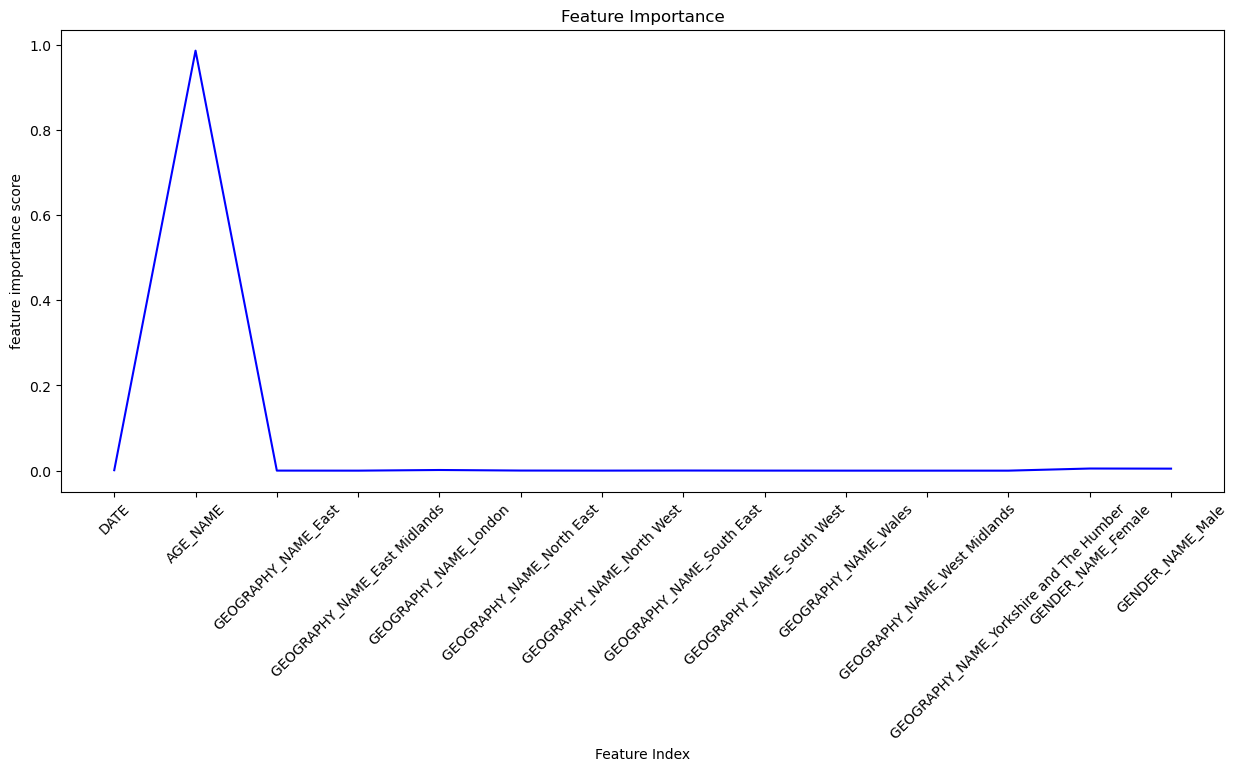

In [160]:
plt.figure(figsize=(15,6))
plt.title("Feature Importance")
plt.plot(train_X.columns, rf.feature_importances_, color='blue')
plt.xticks(rotation=45)
plt.xlabel("Feature Index")
plt.ylabel("feature importance score")

#feature importances show that Age is the most important feature, followed by sex so i will redefine the problem in terms of these two features only

In [161]:
train_X = train_X.loc[:,['DATE','AGE_NAME','GENDER_NAME_Male','GENDER_NAME_Female']]
test_X = test_X.loc[:,['DATE','AGE_NAME','GENDER_NAME_Male','GENDER_NAME_Female']]

scaled_train_X = scaler.fit_transform(train_X)
scaled_test_X = scaler.transform(test_X)

In [162]:
def rmse_score(clf):
    clf.fit(scaled_train_X, train_y.ravel())
    y_pred = clf.predict(scaled_test_X)
    return np.sqrt(np.mean((y_pred - test_y)**2))

In [163]:
# list of hyperparameters I have chosen to optimise:

params = {'n_estimators': (100, 200),
          'max_depth': (1, 5),
          'max_samples': (0.5, 1),
          'min_samples_leaf': (1, 14),
          'max_features': (0,1)}

In [164]:
def bayesOpt_params_rf(n_estimators,max_depth,max_samples, min_samples_leaf,max_features):

    paras = {
        'n_estimators': int(n_estimators),
        'max_depth':int(max_depth),
        'max_samples':max_samples,
        'min_samples_leaf':int(min_samples_leaf),
        'max_features':max_features
    }
    clf = RandomForestRegressor(n_estimators=paras['n_estimators'],max_depth=paras['max_depth'],max_samples=paras['max_samples'],min_samples_leaf=paras['min_samples_leaf'],max_features=paras['max_features'])
    score = rmse_score(clf)
    return score

In [165]:
randfr_bayOpt = BayesianOptimization(bayesOpt_params_rf, params)

In [166]:
param_results = randfr_bayOpt.maximize(n_iter=200, init_points=20)
param_results

|   iter    |  target   | max_depth | max_fe... | max_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 6.943e+03 | 2.26      | 0.8578    | 0.6036    | 2.147     | 145.0     |
| 2         | 6.653e+03 | 4.452     | 0.389     | 0.5172    | 1.987     | 162.7     |
| 3         | 6.515e+03 | 2.819     | 0.6481    | 0.6564    | 5.885     | 171.5     |
| 4         | 6.325e+03 | 3.545     | 0.05844   | 0.5237    | 6.812     | 189.5     |
| 5         | 5.798e+03 | 2.411     | 0.1598    | 0.9054    | 13.77     | 163.1     |
| 6         | 6.418e+03 | 2.263     | 0.5202    | 0.9691    | 2.555     | 180.0     |
| 7         | 6.193e+03 | 1.923     | 0.8508    | 0.8198    | 3.761     | 135.9     |
| 8         | 5.435e+03 | 1.728     | 0.3103    | 0.9704    | 13.98     | 103.6     |
| 9         | 6.253e+03 | 1.69      | 0.9659    | 0.8285    | 9.069     | 200.0     |
| 10        | 6.418e+03 | 3.03      | 0.1583    | 0.54

In [167]:
# optimised hyperparameters of the random forest model
params = randfr_bayOpt.max['params']
params

{'max_depth': 4.769034361282435,
 'max_features': 0.887660464559761,
 'max_samples': 0.8414332543275671,
 'min_samples_leaf': 1.3610611544467859,
 'n_estimators': 199.96591998833352}

In [168]:
rf_new = RandomForestRegressor(max_depth = int(params['max_depth']), n_estimators = int(params['n_estimators']), max_samples = params['max_samples'], min_samples_leaf = int(params['min_samples_leaf']), max_features = params['max_features'])

In [169]:
optimised_model_score = rmse_score(rf_new)
optimised_model_score


7311.182004482575

In [170]:
# How good is our model at predicting mortality on average
rf_new.score(scaled_test_X, test_y)

0.993914148692011

In [171]:
# predict probability of death within one year of a 60 year old male
my_new_input = scaler.transform(np.array([[2023,60,1,0]]).reshape(1,-1))
rf_new.predict(np.array(my_new_input).reshape(1,-1))/100000


C:\Users\mupar\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.00476793])

In [172]:
# predict probability of death within one year of a 30 year old female
my_new_input = scaler.transform(np.array([[2023,30,0,1]]).reshape(1,-1))
rf_new.predict(np.array(my_new_input).reshape(1,-1))/100000

C:\Users\mupar\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0.00187196])